# Evaluating Task Submission Timings
See how Parsl's task submission pipleine scales with different task rates

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime
import pandas as pd
import re
import os

In [2]:
log_re = r"^(?P<date>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) - (?P<module>\S+) - (?P<level>[A-Z]+) - (?P<message>[\s\S]*?)(?=^\d{4})"

Configuration 

In [3]:
run_dir = '../runs/small_basis-16Dec20-002024-cdbd8b/'

## Load in the Logging Messages
Load them in and parse them

In [4]:
with open(os.path.join(run_dir, 'runtime.log')) as fp:
    log_data = pd.DataFrame([x.groupdict() for x in re.finditer(log_re, fp.read(), re.MULTILINE)])
print(f'Parsed {len(log_data)} log lines')

Parsed 92702 log lines


In [5]:
log_data['datetime'] = log_data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S,%f').timestamp())

## Measure Times of Submission Process
Get when a task was pushed from client into queue, recieved and parsed from queue, and launched on Parsl.

In [6]:
push_records = log_data[log_data.message.str.startswith('Client sent a evaluate_mpnn task with topic screen')]
receive_record = log_data[log_data.message.str.startswith('Received a task message with topic screen inbound queue')]
pull_records = log_data[log_data.message.str.startswith('Received request for evaluate_mpnn with topic screen')]
start_records = log_data[log_data.message.str.startswith('Pushed task to Parsl')]
print(f'Found {len(push_records)} task submissions')

Found 5689 task submissions


Measure times

In [7]:
data = pd.DataFrame({
    'start_walltime': a - log_data.datetime.min(),
    'time_received': b - log_data.datetime.min(),
    'push-to-pull': b - a,
    'time-to-decode': c - b,
    'time-to-submit': d - c, 
    'pull-to-submit': d - b,
    'start-to-finish': d - a,
    'finish_walltime': d - log_data.datetime.min()
} for a, b, c, d in zip(push_records.datetime, receive_record.datetime, pull_records.datetime, start_records.datetime))

Compute the time between submit

In [8]:
data['time-to-pull'] = data['time_received'].iloc[1:] - data['finish_walltime'].iloc[:-1].values

In [9]:
data.describe()

,start_walltime,time_received,push-to-pull,time-to-decode,time-to-submit,pull-to-submit,start-to-finish,finish_walltime,time-to-pull
count,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5689.000000,5688.000000
mean,369.347117,369.893131,0.546014,0.001386,0.016034,0.017420,0.563434,369.910551,0.088356
std,153.761954,153.833304,0.503511,0.003584,0.022074,0.023464,0.504785,153.836685,2.318068
min,0.128000,3.157000,-0.004000,0.000000,0.003000,0.003000,0.002000,3.177000,0.000000
25%,268.021000,268.327000,0.033000,0.000000,0.004000,0.004000,0.055000,268.367000,0.000000
50%,380.525000,382.034000,0.471000,0.001000,0.004000,0.005000,0.490000,382.038000,0.001000
75%,493.498000,494.659000,0.893000,0.001000,0.025000,0.027000,0.912000,494.663000,0.014000
max,604.794000,604.825000,3.029000,0.139000,0.431000,0.433000,3.049000,604.828000,172.955000


Text(0.5, 0, 'Walltime (s)')

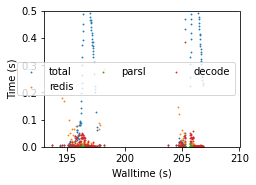

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))


ax.scatter(data['start_walltime'], data['start-to-finish'], s=0.7, label='total')
ax.scatter(data['start_walltime'], data['time-to-pull'], s=0.7, label='redis')
ax.scatter(data['start_walltime'], data['time-to-decode'], s=0.7, label='parsl')
ax.scatter(data['start_walltime'], data['time-to-submit'], s=0.7, label='decode')

ax.set_xlim(193, 210)
ax.set_ylim(0, 0.5)
ax.legend(ncol=3)

ax.set_ylabel('Time (s)')
ax.set_xlabel('Walltime (s)')

*Finding*: Our time to complete each task are only mildly affected by how busy the system is. The long "time to submit" (blue) can be explained by us submitting tasks to Colmena faster than we can clear them, which remains a constant 50ms per task (200 tasks/s)